In [1]:
##############################
# Solves -u'' + u = f        #
# With zero Neumann boundary #
##############################
import radiant as rad
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display


# Problem Parameters
a = 0
b = 2 * np.pi


def u(x):
    return np.cos(x * 2 * np.pi / (b - a))


def f(x):
    return ((2 * np.pi / (b - a)) ** 2 + 1) * np.cos(x * 2 * np.pi / (b - a))


In [2]:
def solve(a, b, f, n, d, k, delta, precond=False):
    centres = np.linspace(a, b, n)
    phi = rad.phi_factory(d, k, delta)

    A = np.zeros((centres.size, centres.size))
    fs = np.zeros_like(centres)
    for i, xi in enumerate(centres):
        fs[i] = rad.integrate.trapezoid(
            lambda x: f(x) * phi(x, xi),
            a, b, 2500
        )

        A[i, i] = rad.integrate.trapezoid(
            lambda x: phi(x, xi, m=1) * phi(x, xi, m=1) +
                      phi(x, xi) * phi(x, xi),
            a, b, 2500
        )

        for j, xj in enumerate(centres[:i]):
            A[i, j] = rad.integrate.trapezoid(
                lambda x: phi(x, xi, m=1) * phi(x, xj, m=1) +
                          phi(x, xi) * phi(x, xj),
                a, b, 2500
            )

            A[j, i] = A[i, j]

    if precond:
        # Jacobi Preconditioning
        pinv = np.diag(1 / np.sqrt(np.diag(A)))

        alphas = pinv @ np.linalg.solve(pinv @ A @ pinv, pinv @ fs)
    else:
        alphas = np.linalg.solve(A, fs)

    return rad.combine(phi, centres, alphas), A, fs, alphas

In [3]:
# Fix delta, vary N
# Parameters
d = 1
k = 1
delta = 1.

Ns = np.linspace(10, 200, 20, dtype=int)
results = np.zeros((Ns.size, 2))

prog = IntProgress(min=0, max=Ns.size)
display(prog)
for i, N in enumerate(Ns):
    # Solve for approximate solution
    u_approx, A, fs, alphas = solve(a, b, f, N, d, k, delta, precond=False)
    error = rad.error(u, u_approx, a, b)
    cond = np.linalg.cond(A)
    
    results[i,:] = [error, cond]
    
    prog.value += 1
    # print("Trial:", i)
    # print("  N:", N)
    # print("  L2 Relative Error:", error)
    # print("  System condition number:", cond)

prog.close()

IntProgress(value=0, max=20)

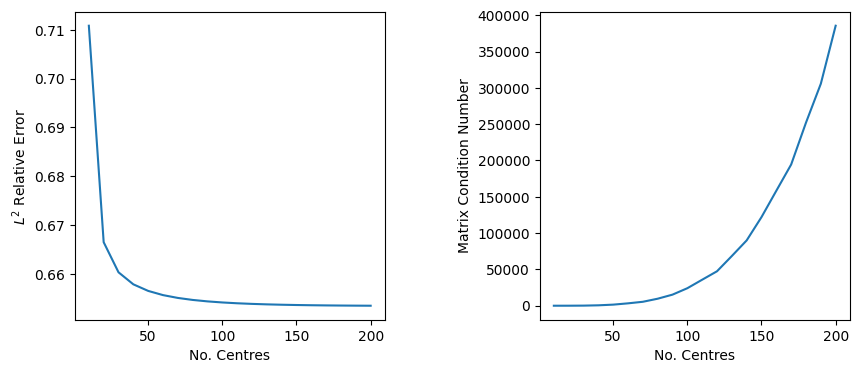

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_xlabel("No. Centres")
axs[0].set_ylabel(r"$L^{2}$ Relative Error")
axs[0].plot(Ns, results[:, 0])

axs[1].set_xlabel("No. Centres")
axs[1].set_ylabel("Matrix Condition Number")
axs[1].plot(Ns, results[:, 1])

plt.subplots_adjust(wspace=0.5)
plt.show()

In [5]:
# Fix delta, vary N
# Parameters
d = 1
k = 1
N = 50

deltas = np.array(range(1, 31)) / 10
results = np.zeros((deltas.size, 2))

prog = IntProgress(min=0, max=deltas.size)
display(prog)
for i, delta in enumerate(deltas):    
    # Solve for approximate solution
    u_approx, A, fs, alphas = solve(a, b, f, N, d, k, delta, precond=False)
    error = rad.error(u, u_approx, a, b)
    cond = np.linalg.cond(A)
    
    results[i,:] = [error, cond]
    
    prog.value += 1
    # print("Trial:", i)
    # print("  delta:", delta)
    # print("  L2 Relative Error:", error)
    # print("  System condition number:", cond)
    
prog.close()

IntProgress(value=0, max=30)

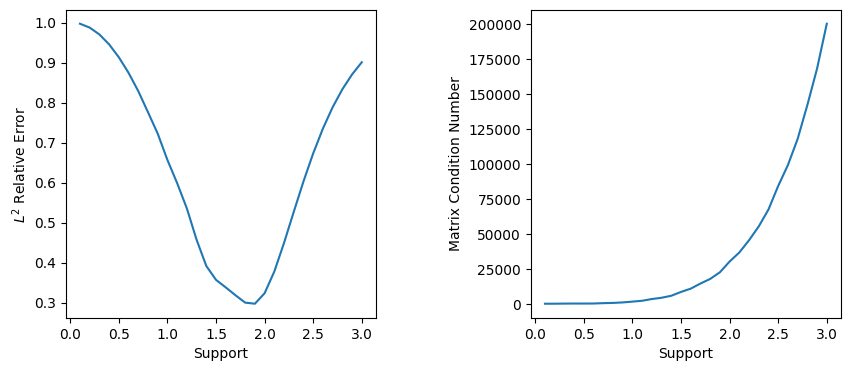

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].set_xlabel("Support")
axs[0].set_ylabel(r"$L^{2}$ Relative Error")
axs[0].plot(deltas, results[:, 0])

axs[1].set_xlabel("Support")
axs[1].set_ylabel("Matrix Condition Number")
axs[1].plot(deltas, results[:, 1])

plt.subplots_adjust(wspace=0.5)
plt.show()